<center>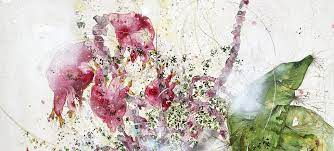</center>

<h6><center>Datacraft</center></h6>

<h1>
<hr style=" border:none; height:3px;">
<center>Atelier 1</center>
<hr style=" border:none; height:3px;">
</h1>

##Preliminaries for the SCM part

Import useful libraries

In [83]:
!pip install dowhy
!apt install libgraphviz-dev
!pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-3build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
import numpy as np
import random
from scipy import stats
import time
from collections import defaultdict
import warnings
from scipy.stats import rankdata
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import dowhy
from dowhy import CausalModel
import graphviz as gr
import pygraphviz

Useful functions for the SCM part

In [3]:
def same(x):
    return x
    
def cube(x):
    return np.power(x, 3)

def negexp(x):
    return np.exp(-np.abs(x))

##Preliminaries for the estimation of effects parts

Install the shap library

In [4]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import useful librairies

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import shap

Create functions that provide plots of RF importances for a given set of preds and outcome


In [6]:
def get_importances(predictors, outcome, feature_names, standardize=False):
    '''Gets bi-covs, bi-corrs,linear reg coeffs, RF importances, RF shap and MLP/NN shap output.
    :param predictors: array of preds (N, D)
    :param outcome: array of outcome (N, 1)
    :param feature_names: list of var names as strings
    :param standardize: where to standardize the data (does not apply to the computation of
    biv_covs, biv_corrs, or lr_coefs).
    :return as np.arrays (D,) of biv_corrs, biv_covs, rf_imps, rf_shaps, nn_shap, lin_coefs'''
    
    biv_covs = []
    biv_corrs = []
    for i in range(predictors.shape[1]):
        biv_covs.append(np.abs(np.cov(predictors[:, i], outcome,))[0,1])
        biv_corrs.append(np.abs(np.corrcoef(predictors[:, i], outcome,))[0,1])
        
    print('------------LR (always unstandardizd)---------------')
    # compare with linear regression coefficients
    reg = LinearRegression().fit(predictors, outcome)
    X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)
    predictions = reg.predict(X_test)
    lr_coefs =  np.abs(reg.coef_)
    print('MSE', mean_squared_error(predictions, y_test))
    
        
    if standardize:
        predictors = ((predictors - predictors.mean(0)) / (predictors.std(0)))
        X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)

    
    print('------------RF---------------')
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train)
    predictions = forest.predict(X_test)
    rf_importances = forest.feature_importances_

    
    shap_sample_inds_train = np.random.choice(np.arange(0,len(X_train)), 500)
    shap_sample_inds_test = np.random.choice(np.arange(0,len(X_test)), 500)
    explainer = shap.TreeExplainer(forest, X_train[shap_sample_inds_train])
    rf_shap_vals = np.mean(np.abs(explainer.shap_values(X_test[shap_sample_inds_test], approximate=True)),0)
    print('MSE', mean_squared_error(predictions, y_test))
    
    print('------------NN---------------')
    nn_regr = MLPRegressor(hidden_layer_sizes=(100,),
                           activation='relu', solver='adam', alpha=0.0001,
                           batch_size='auto', learning_rate='adaptive',
                           learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,)
    nn_regr.fit(X_train, y_train)
    predictions = nn_regr.predict(X_test)
    
    explainer = shap.KernelExplainer(nn_regr.predict, shap.sample(X_train, 500))
    nn_shap_vals = np.mean(np.abs(explainer.shap_values(X_test, nsamples=500)),0)
    print('MSE', mean_squared_error(predictions, y_test))
    
    

    return np.asarray(biv_covs), np.asarray(biv_corrs), rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs

In [7]:
def plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coef, feature_names, graph_name):
    '''Bar plot with variables and different importance measures.'''
    
    all_results = pd.DataFrame([lr_coef, rf_importances, rf_shap_vals, nn_shap_vals]).T
    all_results.index = feature_names
    cols = ['LR-coefs', 'RF-imps', 'RF-Shap', 'NN-Shap']
    all_results.columns = cols
#     min_, max_ = all_results.min(), all_results.max()
#     m = (1 - min_) / (max_ - min_)
#     b = min_ - m*min_
#     all_results = all_results *m + b
    all_results.clip(lower=0, upper=1, inplace=True)
    all_results['bi-corrs'] = biv_corrs
    all_results['Var Names'] = all_results.index

    ax = plt.figure(figsize=(10, 6)).add_subplot(111)
    all_results.plot(ax=ax, x="Var Names", y=cols.append('bi-corrs'), kind="bar",fontsize=16, alpha=0.7)
    bars = ax.patches
    hatches = ''.join(h*len(all_results) for h in 'x/O.')
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=5,fontsize=12)
    ax.set_ylim(0, 1.15)
    ax.figure.savefig(graph_name, dpi=200)

####**Basic situations**

We shall generate four basic situations

### **Situation 1 : Independency**
$X$ and $Y$ are independent

In [9]:
def generate_samples_indep(size,fixed_function1,fixed_function2, normalize = True, seed = None):
    '''Generate independent post-nonlinear samples
    Arguments:
        size : number of samples
        f1, f2 to be within {x,x^2,x^3, e^{-|x|}, cos x}
    Output:
        Samples X, Y
    '''
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if fixed_function1 == 'linear':
      f1 = same
    elif fixed_function1=='carre':
      f1 = np.square
    elif fixed_function1=='cube':
      f1 = cube
    elif fixed_function1=='negexp':
      f1 = negexp
    else:
      f1 = np.cos

    if fixed_function2 == 'linear':
      f2= same
    elif fixed_function2=='carre':
      f2 = np.square
    elif fixed_function2=='cube':
      f2 = cube
    elif fixed_function2=='negexp':
      f2 = negexp
    else:
      f2 = np.cos

    X = f1(np.random.normal(0, 1, size))
    Y = f2(np.random.normal(0, 1, size))

    if normalize == True:
        X = (X - X.min()) / (X.max() - X.min())
        Y = (Y - Y.min()) / (Y.max() - Y.min())

    return np.array(X), np.array(Y)

### **Situation 2 : Fork**  
$Z$ is a common cause to $X$ and $Y$.

We represent the graphical model

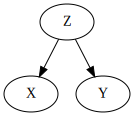

In [10]:
g = gr.Digraph()
g.edge("Z", "X"), g.edge("Z", "Y")
g

To simulate a fork, we shall use the following SCM  \\
$$X=f_1(a_1\cdot Z+\varepsilon_1)$$
$$Y=f_2(a_2\cdot Z+\varepsilon_2)$$
where $(Z,\varepsilon_1,\varepsilon_2)$ are independent r.v.'s and where the variance of the two noise variables $\varepsilon_1$ and $\varepsilon_2$ are $\sigma^2$

In [11]:
def generate_samples_fork(size,fixed_function1,fixed_function2, dist_z,dz,aX,aY,nstd,normalize = True, seed = None):
    '''Generate independent post-nonlinear samples
    Arguments:
        size : number of samples
        f1, f2 to be within {x,x^2,x^3, e^{-|x|}, cos x}
    Output:
        Samples X, Y,Z
    '''
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if fixed_function1 == 'linear':
      f1 = same
    elif fixed_function1=='carre':
      f1 = np.square
    elif fixed_function1=='cube':
      f1 = cube
    elif fixed_function1=='negexp':
      f1 = negexp
    else:
      f1 = np.cos

    if fixed_function2 == 'linear':
      f2= same
    elif fixed_function2=='carre':
      f2 = np.square
    elif fixed_function2=='cube':
      f2 = cube
    elif fixed_function2=='negexp':
      f2 = negexp
    else:
      f2 = np.cos
    
    if dist_z =='gaussian':
        cov = np.eye(dz)
        mu = np.ones(dz)
        Z = np.random.multivariate_normal(mu, cov, size)
        Z = np.matrix(Z)

    elif dist_z == 'laplace':
        Z = np.random.laplace(loc=0.0, scale=1.0, size=size*dz)
        Z = np.reshape(Z,(size,dz))
        Z = np.matrix(Z)

    X = f1(np.dot(aX,Z)+nstd * np.random.normal(0, 1, (size, 1)))
    Y = f2(np.dot(aY,Z)+nstd * np.random.normal(0, 1, (size, 1)))

    if normalize == True:
        X = (X - X.min()) / (X.max() - X.min())
        Y = (Y - Y.min()) / (Y.max() - Y.min())
        Z = (Z - Z.min()) / (Z.max() - Z.min())

    return np.array(X), np.array(Y),np.array(Z)

###**Situation 3 : collider**
$Z$ has two causes $X$ and $Y$

We represent the graphical model 

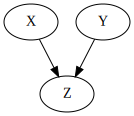

In [12]:
g = gr.Digraph()
g.edge("X", "Z"), g.edge("Y", "Z")
g

To simulate a collider, we simulate the corresponding SCM :
$$Z=f(a_X\cdot X+a_Y\cdot Y+\varepsilon)$$
with $(\varepsilon,X,Y)$ independent random variables

In [13]:
def generate_samples_collider(size,fixed_function, dist_x,dist_y,dx,dy,aX,aY,nstd,normalize = True, seed = None):
    '''Generate independent post-nonlinear samples
    Arguments:
        size : number of samples
        f1, f2 to be within {x,x^2,x^3, e^{-|x|}, cos x}
    Output:
        Samples X, Y,Z
    '''
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if fixed_function == 'linear':
      f = same
    elif fixed_function=='carre':
      f = np.square
    elif fixed_function=='cube':
      f = cube
    elif fixed_function=='negexp':
      f = negexp
    else:
      f = np.cos

    if dist_x =='gaussian':
        cov = np.eye(dx)
        mu = np.ones(dx)
        X = np.random.multivariate_normal(mu, cov, size)
        X = np.matrix(X)

    elif dist_x == 'laplace':
        X = np.random.laplace(loc=0.0, scale=1.0, size=size*dx)
        X = np.reshape(X,(size,dx))
        X = np.matrix(X)

    if dist_y =='gaussian':
        cov = np.eye(dy)
        mu = np.ones(dy)
        Y = np.random.multivariate_normal(mu, cov, size)
        Y = np.matrix(Y)

    elif dist_y == 'laplace':
        Y = np.random.laplace(loc=0.0, scale=1.0, size=size*dy)
        Y = np.reshape(Y,(size,dy))
        Y = np.matrix(Y)

    Z = f(np.dot(aX,X)+np.dot(aY,Y)+nstd * np.random.normal(0, 1))
    
    if normalize == True:
        X = (X - X.min()) / (X.max() - X.min())
        Y = (Y - Y.min()) / (Y.max() - Y.min())
        Z = (Z - Z.min()) / (Z.max() - Z.min())

    return np.array(X), np.array(Y),np.array(Z)

### **Situation 4 : chain**
$X$ is a cause of $Y$ which is itself a cause of $Z$

We represent the graphical model

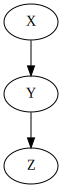

In [14]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("Y", "Z")
g

To simulate a chain, we simulate the corresponding SCM :
$$Y=f(a_X X+\varepsilon_1)$$
$$Z=f(a_Y Y+\varepsilon_2)$$
with $(\varepsilon_1,\varepsilon_2,X)$ independent random variables

In [15]:
def generate_samples_chain(size,fixed_function, dist_x,dx,aX,aY,nstd,normalize = True, seed = None):
    '''Generate independent post-nonlinear samples
    Arguments:
        size : number of samples
        f1, f2 to be within {x,x^2,x^3, e^{-|x|}, cos x}
    Output:
        Samples X, Y,Z
    '''
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if fixed_function == 'linear':
      f = same
    elif fixed_function=='carre':
      f = np.square
    elif fixed_function=='cube':
      f = cube
    elif fixed_function=='negexp':
      f = negexp
    else:
      f = np.cos

    if dist_x =='gaussian':
        cov = np.eye(dx)
        mu = np.ones(dx)
        X = np.random.multivariate_normal(mu, cov, size)
        X = np.matrix(X)

    elif dist_x == 'laplace':
        X = np.random.laplace(loc=0.0, scale=1.0, size=size*dx)
        X = np.reshape(X,(size,dx))
        X = np.matrix(X)

    Y = f(np.dot(aX,X)+nstd * np.random.normal(0, 1))
    Z = f(aY*Y+nstd * np.random.normal(0, 1))
    
    if normalize == True:
        X = (X - X.min()) / (X.max() - X.min())
        Y = (Y - Y.min()) / (Y.max() - Y.min())
        Z = (Z - Z.min()) / (Z.max() - Z.min())

    return np.array(X), np.array(Y),np.array(Z)

### **Intervention and counterfactual through an example**

We simulate an example
$$T=f_1(a_1\cdot X+\varepsilon_1)$$
$$Y=f_2(a_2\cdot T+ b_2\cdot X+\varepsilon_2)$$
where $X,\varepsilon_1,\varepsilon_2$ are independent random variables whose distribution is known

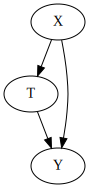

In [18]:
g = gr.Digraph()
g.edge("X", "T"), g.edge("T", "Y"), g.edge("X", "Y")
g

Generation of the SCM

In [16]:
def generate_samples(size,fixed_function1,fixed_function2, dist_x,dx,a1,a2,b2,nstd,seed = None,normalize=True):
    '''Generate independent post-nonlinear samples
    Arguments:
        size : number of samples
        f1, f2 to be within {x,x^2,x^3,tanh x, e^{-|x|}, cos x}
    Output:
        Samples X,T,Y
    '''
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if fixed_function1 == 'linear':
      f1 = same
    elif fixed_function1=='carre':
      f1 = np.square
    elif fixed_function1=='cube':
      f1 = cube
    elif fixed_function1=='negexp':
      f1 = negexp
    else:
      f1 = np.cos

    if fixed_function2 == 'linear':
      f2= same
    elif fixed_function2=='carre':
      f2 = np.square
    elif fixed_function2=='cube':
      f2 = cube
    elif fixed_function2=='negexp':
      f2 = negexp
    else:
      f2 = np.cos
    
    if dist_x =='gaussian':
        cov = np.eye(dx)
        mu = np.ones(dx)
        X = np.random.multivariate_normal(mu, cov, size)

    elif dist_x == 'laplace':
        X = np.random.laplace(loc=0.0, scale=1.0, size=size*dx)
        if (dx!=1):
          X = np.reshape(X,(size,dx))

    T = f1(np.dot(a1,X)+nstd * np.random.normal(0, 1, size))
    Y = f2(np.dot(a2,T)+b2*X+nstd * np.random.normal(0, 1, size))

    if normalize == True:
        X = (X - X.min()) / (X.max() - X.min())
        T = (T - T.min()) / (T.max() - T.min())
        Y = (Y - Y.min()) / (Y.max() - Y.min())

    return [X,T,Y]

In [17]:
[X,T,Y]=generate_samples(100,'cube','carre', 'gaussian',1,1.0,2.0,1.0,1.0,43)
df_mediator=pd.DataFrame({'X':X[:,0],'T':T[:,0],'Y':Y[:,0]})
df_mediator

,X,T,Y
0,0.534263,0.260569,0.000540
1,0.263968,0.249165,0.000028
2,0.386837,0.251142,0.000085
3,0.350574,0.250173,0.000057
4,0.673522,0.281381,0.002728
...,...,...,...
95,0.423019,0.252553,0.000132
96,0.497060,0.257181,0.000337
97,0.430913,0.252929,0.000145
98,0.843581,0.329592,0.013870


Simulation of a hard intervention

In [19]:
def generate_samples_intervene(size,fixed_function1,fixed_function2, value_t,dist_x,dx,a1,a2,b2,nstd,seed = None,normalize=True):
    '''Generate independent post-nonlinear samples
    Arguments:
        size : number of samples
        f1, f2 to be within {x,x^2,x^3,tanh x, e^{-|x|}, cos x}
    Output:
        Samples T, M,Y
    '''
    print(seed)
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if fixed_function1 == 'linear':
      f1 = same
    elif fixed_function1=='carre':
      f1 = np.square
    elif fixed_function1=='cube':
      f1 = cube
    elif fixed_function1=='negexp':
      f1 = negexp
    else:
      f1 = np.cos

    if fixed_function2 == 'linear':
      f2= same
    elif fixed_function2=='carre':
      f2 = np.square
    elif fixed_function2=='cube':
      f2 = cube
    elif fixed_function2=='negexp':
      f2 = negexp
    else:
      f2 = np.cos
    
    if dist_x =='gaussian':
        cov = np.eye(dx)
        mu = np.ones(dx)
        X = np.random.multivariate_normal(mu, cov, size)

    elif dist_x == 'laplace':
        X = np.random.laplace(loc=0.0, scale=1.0, size=size*dx)
        if (dx!=1):
          X = np.reshape(X,(size,dx))


    Y = f2(np.dot(a2,value_t)+b2*X+nstd * np.random.normal(0, 1, size))

    if normalize == True:
        X = (X - X.min()) / (X.max() - X.min())
        T =value_t*np.ones((len(X),1))
        Y = (Y - Y.min()) / (Y.max() - Y.min())

    return [X,T,Y]

We intervene on $T$ setting $T:=3$

In [20]:
[X,T,Y]=generate_samples_intervene(100,'cube','carre', 3.0,'gaussian',1,1,2,1,1,43)
df_intervene=pd.DataFrame({'X':X[:,0],'T':T[:,0],'Y':Y[:,0]})
df_intervene

43


,X,T,Y
0,0.534263,3.0,0.377819
1,0.263968,3.0,0.261186
2,0.386837,3.0,0.311753
3,0.350574,3.0,0.296404
4,0.673522,3.0,0.445627
...,...,...,...
95,0.423019,3.0,0.327423
96,0.497060,3.0,0.360593
97,0.430913,3.0,0.330889
98,0.843581,3.0,0.535549


### **Counterfactuals**

We assume now that we have observed $(X,T,Y)=(1,-1,1)$ with $f_1=f_2:=t\mapsto t$, $a_1=a_2=b_2=1$.

What are the value of the two noises $\varepsilon_1,\varepsilon_2$?

What would have happen if $T:=2$?

###**Estimation of the effects on a complex example**

### **Example** 1

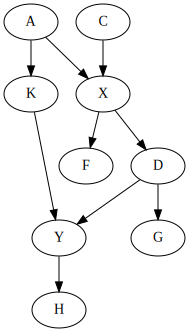

In [21]:
g = gr.Digraph()
g.edge("A", "K"), g.edge("C", "X"), g.edge("A", "X"),g.edge("X","F"), g.edge("X","D"),g.edge("D","G"),g.edge("K","Y"),g.edge("D","Y"),g.edge("Y","H")
g

We associate a LinGAM to this graph 

In [34]:
N = 200

###############################################################
######## EITHER RUN: ########
low_corr = 0
C = np.random.randn(N,1)   # exogenous cause of X
A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
K = A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
X = C - 2*A + 0.2 * np.random.randn(N,1)  # treatment variable
F = 3*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
D = -2*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
G = D + 0.5 * np.random.randn(N,1)  # descendent of mediator
Y = 2*K - D + 0.2 * np.random.randn(N,1)  # outcome variable 
H = 0.5*Y + 0.1 * np.random.randn(N,1)  # effect of Y

feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']

### Investigate $X\rightarrow Y$ using classical importance measures. Start by looking at the result with ALL variables 

In [35]:
predictors = np.concatenate((C, A, K, X, F, D, G, H),1)
outcome =  Y[:,0]

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='all_preds.png')

biv_covs_a,biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a = get_importances(predictors, outcome, feature_names, standardize=True)

for i, corr in enumerate(biv_corrs_a):
    print(feature_names[i], corr)

------------LR (always unstandardizd)---------------
MSE 0.02337809729280256
------------RF---------------
MSE 0.13683769358426737
------------NN---------------


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.12846029190298772
C 0.7498153437579995
A 0.6019613677053702
K 0.5927080657107614
X 0.9168188349071246
F 0.9029963533325801
D 0.9352800306157703
G 0.9280202710685885
H 0.9972101572259061


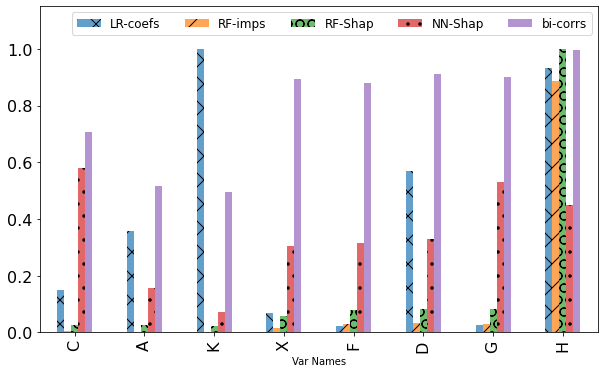

In [29]:
gn = 'all_preds_std.png' if not low_corr else 'all_preds_std_low_corr.png'
plot_results(biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a, feature_names, graph_name=gn)

##Let's remove the effect of Y, which is 'H'


------------LR (always unstandardizd)---------------
MSE 0.04027988261571567
------------RF---------------
MSE 0.4491305656602008
------------NN---------------


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.1976701923468211


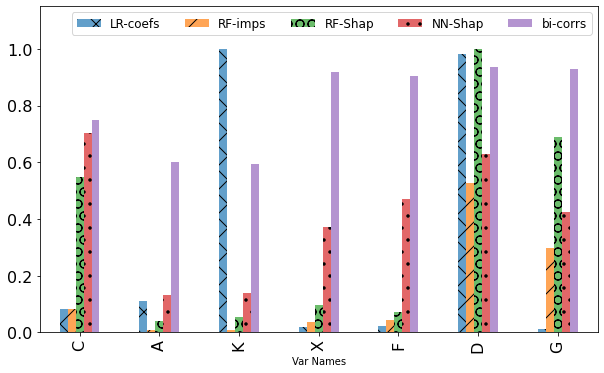

In [36]:
# remove effect of y
predictors = np.concatenate((C, A, K, X, F, D, G),1)
outcome =  Y[:,0]
feature_names_b = ['C', 'A', 'K', 'X', 'F', 'D', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H.png')
gn = 'no_H_std.png' if not low_corr else 'no_H_std_low_corr.png'
biv_covs_b,biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b = get_importances(predictors, outcome, feature_names_b, standardize=True)
plot_results(biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b, feature_names_b, graph_name=gn)

##Now let's remove the mediator 'D'. Surely now we will see 'X' linked with 'Y'?

------------LR (always unstandardizd)---------------
MSE 0.15728017169340608
------------RF---------------
MSE 0.49775281458470355
------------NN---------------


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.27825702360670385


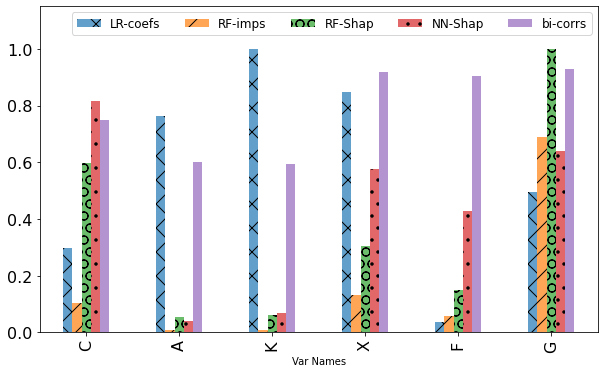

In [37]:
# remove mediator
predictors = np.concatenate((C, A, K, X, F, G),1)
outcome =  Y[:,0]
feature_names_c = ['C', 'A', 'K', 'X', 'F', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H_no_D.png')

biv_covs_c,biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c = get_importances(predictors, outcome, feature_names_c, standardize=True)
gn = 'no_H_no_D_std.png' if not low_corr else 'no_H_no_D_std_low_corr.png'
plot_results(biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c, feature_names_c, graph_name=gn)

### **Example 2**

In [ ]:
# #Alternatively, with lower levels of association
low_corr = 1 
C = np.random.randn(N,1)   # exogenous cause of X
A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
K = 0.2*A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
X = 0.2*C - 0.4*A + 0.2 * np.random.randn(N,1)  # treatment variable
F = 0.6*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
D = -0.4*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
G = 0.2*D + 0.5 * np.random.randn(N,1)  # descendent of mediator
Y = 0.4*K - D + 0.2 * np.random.randn(N,1)  # outcome variable 
H = 0.1*Y + 0.1 * np.random.randn(N,1)  # effect of Y
# ###############################################################
feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']

### **Estimation of the causal effect using the library dowhy**

In [85]:
example1_array=np.concatenate((C, A, K, X, F, D, G, Y,H),axis=1)
df = pd.DataFrame(data = example1_array, columns=['C', 'A', 'K', 'X', 'F', 'D', 'G', 'Y','H'])

In [87]:
causal_graph = """digraph {
F;
G;
H;
A->K;
A->X;
C->X;
X->F;
X->D;
K->Y;
D->Y;
D->G;
Y->H;
}"""

In [89]:
model=CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment="X",
        outcome="Y"
        )

In [90]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|A])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,A,U) = P(Y|X,A)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[C]    ⎝d[C]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{C})
Estimand assumption 2, Exclusion: If we remove {C}→{X}, then ¬({C}→Y)

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([D])⎥
 ⎣d[D]    d[X]     ⎦
Estimand assumption 1, Full-mediation: D intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{D} then P(D|X,U) = P(D|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{D} and U→Y then P(Y|D, X, U) = P(Y|D, X)



In [93]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|A])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,A,U) = P(Y|X,A)

## Realized estimand
b: Y~X+A+X*K
Target units: ate

## Estimate
Mean value: 2.032792434187587

